<a href="https://colab.research.google.com/github/janakanchandru/rap-lyric-generator/blob/master/effect_of_embedding_dimension.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rap Lyrics Generator
## This file is for seeing how embedding dimensions affects the performance of the model
Imports:

In [0]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from random import shuffle
from tqdm import tqdm
import math

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}, to remove tf console output

### Helper Functions

Mappings used to split dataset

In [0]:
def split_input_target(chunk):
    input_seq = chunk[:-1]
    target = chunk[-1]
    return input_seq, target

def make_target_categorical(X, y):
    vocabSet_size = 7016 # unfortunatley this needs to be hardcoded, can't find a dynamic way
    y = tf.one_hot(y, vocabSet_size)
    return X, y

Function to convert encoded examples to words

In [0]:
def convert_to_word(X, y_idx, idx_not_in_vocabSet, idx2word):
    word_X = ''
    word_y = ''

    for idx in X:
        if idx == idx_not_in_vocabSet:
            word_X += 'n/a '
        else:
            word_X += idx2word[idx] + ' '

    if y_idx == idx_not_in_vocabSet:
        word_y = 'n/a (word not in vocabSet)'
    else:
        word_y = idx2word[y_idx]

    return word_X, word_y

Function to process the data and create a TF dataset object for training

In [0]:
def preprocess(encoded_train_set_filename, vocab_set_filename, word2idx_filename, idx2word_filename, 
                seq_length, batch_size, num_examples_to_use=0):
    # get training data
    songData = []
    with open(encoded_train_set_filename, 'r') as f:
        for song in f.read().splitlines():
            song_split = song.split()
            add = []
            for num in song_split:
                add.append(int(num))
            songData.append(add)

    # load vocabSet
    vocabSet = []
    with open(vocab_set_filename, 'r') as f:
        vocabSet = f.read().splitlines()

    vocabSet_size = len(vocabSet) + 1
    idx_not_in_vocabSet = len(vocabSet)

    # load lookup tables
    word2idx = np.load('data/word2idx.npy', allow_pickle=True).item()
    idx2word = np.load('data/idx2word.npy', allow_pickle=True)

    # split lyrics into segments of len = seq_length
    print('Splitting songs into sequences of seq_length...')
    sequences = []
    for song in tqdm(songData):
        for i in range(seq_length+1, len(song)):
            sequences.append(song[i - (seq_length+1) : i])
    if num_examples_to_use:
        sequences = sequences[:num_examples_to_use]

    train_idx = math.ceil(num_examples_to_use * 0.75)
    train_sequences = sequences[:train_idx]
    val_sequences = sequences[train_idx:]

    print('Test set contains {} sequences'.format(len(train_sequences)))
    print('Validation set contains {} sequences'.format(len(val_sequences)))
    
    # create TF dataset, allows for large datasets without memory issues
    print('\nCreating TF dataset object out of sequences, this may take awhile...')
    print('MAKE SURE you input the correct vocabSet size in make_target_categorical(): ', vocabSet_size)
    sequences_train_dataset = tf.data.Dataset.from_tensor_slices(train_sequences)
    sequences_val_dataset = tf.data.Dataset.from_tensor_slices(val_sequences)

    train_dataset = sequences_train_dataset.map(split_input_target)
    train_dataset = train_dataset.map(make_target_categorical)

    val_dataset = sequences_val_dataset.map(split_input_target)
    val_dataset = val_dataset.map(make_target_categorical)

    buffer_size = 10000
    train_dataset = train_dataset.shuffle(buffer_size).batch(batch_size, drop_remainder=True)
    val_dataset = val_dataset.shuffle(buffer_size).batch(batch_size, drop_remainder=True)

    print('\nTotal # of training examples: ', len(sequences))

    print('\nDataset created')

    return vocabSet, word2idx, idx2word, train_dataset, val_dataset

## Model Class

In [0]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

class ModelV1:
    def __init__(self):
        self.SEQ_LENGTH = 100
        self.BATCH_SIZE = 128
        self.EMBEDDING_DIM = 256
        self.RNN_UNITS = 512

    def build_model(self, vocab_size, embedding_dims):
        self.EMBEDDING_DIM = embedding_dims

        model = tf.keras.Sequential([
            Embedding(vocab_size, self.EMBEDDING_DIM, input_length=self.SEQ_LENGTH),

            tf.keras.layers.LSTM(self.RNN_UNITS, 
                                return_sequences=False,
                                stateful=False,
                                recurrent_initializer='glorot_uniform'),

            tf.keras.layers.Dense(vocab_size, activation='softmax')
        ])
        model.summary()

        return model

## Training

In [0]:
# Constants
EPOCHS = 30
NUM_EXAMPLES_TO_USE = 200000 # if you want to limit the number of examples used for training
TRAIN_SET_FILENAME = 'data/encoded_train_val_set.txt'
VOCABSET_FILENAME = 'data/vocabSet.txt'
WORD2IDX_FILENAME = 'data/word2idx.npy'
IDX2WORD_FILENAME = 'data/idx2word.npy'

# prepare checkpoint directory
checkpoint_dir = 'results'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [0]:
# initate model
modelv1 = ModelV1()
params = [modelv1.EMBEDDING_DIM, modelv1.RNN_UNITS, modelv1.SEQ_LENGTH, modelv1.BATCH_SIZE]

In [0]:
# prepare data
vocabSet, word2idx, idx2word, train_dataset, val_dataset = preprocess(TRAIN_SET_FILENAME, 
                                                                      VOCABSET_FILENAME,
                                                                      WORD2IDX_FILENAME,
                                                                      IDX2WORD_FILENAME,
                                                                      params[2], 
                                                                      params[3],
                                                                      NUM_EXAMPLES_TO_USE)

  1%|          | 24/2759 [00:00<00:17, 153.42it/s]

Splitting songs into sequences of seq_length...


100%|██████████| 2759/2759 [00:05<00:00, 474.69it/s]


Test set contains 150000 sequences
Validation set contains 50000 sequences

Creating TF dataset object out of sequences, this may take awhile...
MAKE SURE you input the correct vocabSet size in make_target_categorical():  7016

Total # of training examples:  200000

Dataset created


In [0]:
# build and train models
embedding_dims = [64, 128, 256, 512, 1024]
val_accuracies = []
val_entropies = []
val_acc_metric = tf.keras.metrics.CategoricalAccuracy()
val_entropy_metric = tf.keras.metrics.CategoricalCrossentropy()

for dims in embedding_dims:
  model = modelv1.build_model(len(vocabSet)+1, dims)
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', 'crossentropy'])
  history = model.fit(train_dataset, batch_size=params[3], epochs=EPOCHS, callbacks=[checkpoint_callback])

  for x_batch_val, y_batch_val in val_dataset:
    val_logits = model(x_batch_val)
    val_acc_metric(y_batch_val, val_logits)
    val_entropy_metric(y_batch_val, val_logits)

  val_accuracies.append(val_acc_metric.result().numpy())
  val_entropies.append(val_entropy_metric.result().numpy())

  val_acc_metric.reset_states()
  val_entropy_metric.reset_states()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 64)           449024    
_________________________________________________________________
lstm (LSTM)                  (None, 512)               1181696   
_________________________________________________________________
dense (Dense)                (None, 7016)              3599208   
Total params: 5,229,928
Trainable params: 5,229,928
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
1171/1171 [==============================] - 55s 47ms/step - loss: 5.7387 - accuracy: 0.1348 - crossentropy: 5.7387
Epoch 2/30
1171/1171 [==============================] - 56s 48ms/step - loss: 5.2462 - accuracy: 0.1655 - crossentropy: 5.2462
Epoch 3/30
1171/1171 [==============================] - 56s 48ms/step - loss: 4.9620 - accuracy: 0.1816 - crossentropy: 4.

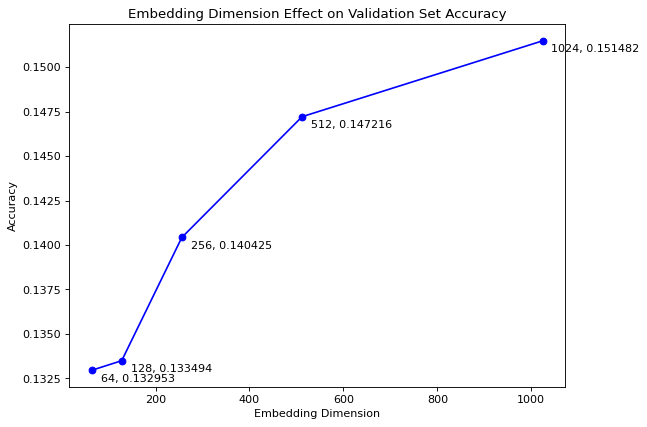

In [0]:
# plot accuracies vs embedding_dims
import matplotlib.pyplot as plt
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.xlabel('Embedding Dimension')
plt.ylabel('Accuracy')
plt.title('Embedding Dimension Effect on Validation Set Accuracy')
plt.plot(embedding_dims, val_accuracies, 'bo-')
for x,y in zip(embedding_dims, val_accuracies):
    label = "{}, {:4f}".format(x, y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(8,-10), # distance from text to points (x,y)
                 ha='left') # horizontal alignment can be left, right or center

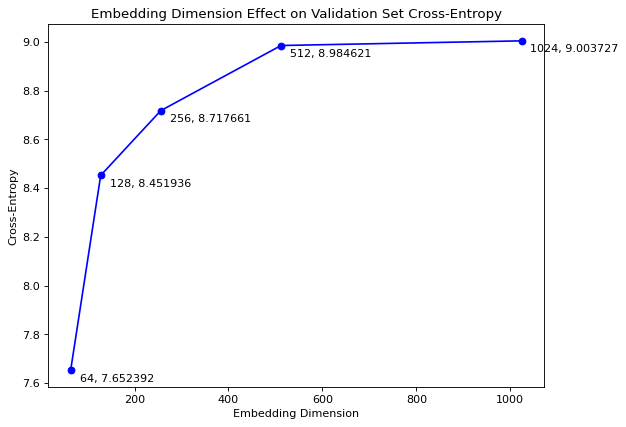

In [0]:
# plot cross-entropies vs embedding_dims
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.xlabel('Embedding Dimension')
plt.ylabel('Cross-Entropy')
plt.title('Embedding Dimension Effect on Validation Set Cross-Entropy')
plt.plot(embedding_dims, val_entropies, 'bo-')
for x,y in zip(embedding_dims, val_entropies):
    label = "{}, {:4f}".format(x, y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(8,-10), # distance from text to points (x,y)
                 ha='left') # horizontal alignment can be left, right or center